Let's suppose that we are working for a company that has been tasked with the creation of a system that will notify civilians in case a natural disaster occures. This system will use tweets to try to predict such scenarios. We will classify tweets into events that showcase whether a disaster is underway or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from techniques import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

The dataset is from https://www.kaggle.com/competitions/nlp-getting-started.

We will only use the training file (and split it further into train and test set) according to the project instructions.

In [2]:
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Target=1 means natural disaster. Zero otherwise.

In [3]:
x=train.drop(columns=['target'])
y=train[['target']]

In [4]:
seed = 0
test_size = 0.1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed,stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851, 4), (6851, 1), (762, 4), (762, 1))

In [5]:
x_train

,id,keyword,location,text
6669,9557,threat,"BiÌ±an,Laguna",Meek Mill responds to DrakeÛªs OVO Fest set w...
3940,5602,flood,NaN,survived the plague\nfloated the flood\njust p...
7217,10336,weapons,"California, United States",#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...
2234,3193,deluge,"Fort Fizz, Ohio",Vince McMahon once again a billionaire: I reme...
4233,6013,hazardous,"Oregon, USA",Is it possible to sneak into a hospital so I c...
...,...,...,...,...
3865,5496,flames,Travelling around the world,@AWickedAssassin want to burst into flames! *A...
6854,9823,trauma,"Houston, TX",Photo: lavenderpoetrycafe: The Forgotten Histo...
5669,8089,rescue,India,Officials rescue 367 migrants off Libya; 25 bo...
3397,4864,explode,|IG: imaginedragoner,If Ryan doesn't release new music soon I might...


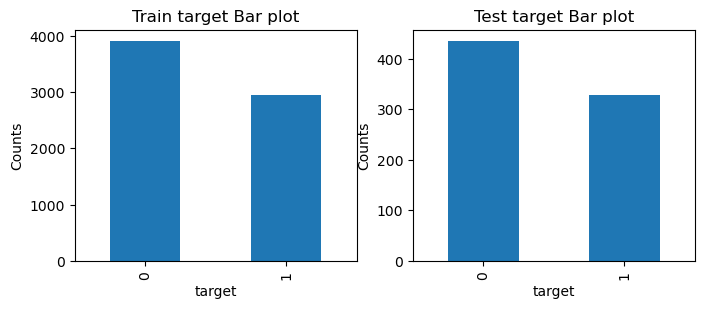

In [6]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

plt.subplot(1,2,1)
y_train['target'].value_counts().plot.bar()
plt.title('Train target Bar plot')
plt.xlabel('target')
plt.ylabel('Counts')

plt.subplot(1,2,2)
y_test['target'].value_counts().plot.bar()
plt.title('Test target Bar plot')
plt.xlabel('target')
plt.ylabel('Counts')

plt.show()

We can observe that the dataset is slightly unbalanced.

In [7]:
x_train=x_train.drop(columns=['id','location'])
x_test=x_test .drop(columns=['id','location'])
x_train = x_train.fillna(value="null")
x_test = x_test.fillna(value="null")

In [8]:
x_train["inputs"] = x_train["keyword"] + " " + x_train["text"]
x_test["inputs"] = x_test["keyword"] + " " + x_test["text"]
x_train

,keyword,text,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,hazardous Is it possible to sneak into a hospi...
...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,flames @AWickedAssassin want to burst into fla...
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,trauma Photo: lavenderpoetrycafe: The Forgotte...
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,rescue Officials rescue 367 migrants off Libya...
3397,explode,If Ryan doesn't release new music soon I might...,explode If Ryan doesn't release new music soon...


We will now use functions from the below github project, in order to preprocess text data.

In [9]:
#based on the logic of https://github.com/Deffro/text-preprocessing-techniques/tree/master
def removesymbol(text):
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  return text

In [10]:
def clean_df(df):
  df_clean = df.copy()
  df_clean['clean_inputs'] =  df['inputs'].apply(removeUnicode) #reomves unicode text
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(replaceURL) #replaces url with the word url
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(replaceAtUser) #replaces user mentions with the word atuser
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(removeHashtagInFrontOfWord) #removes the hashtag symbol
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(replaceMultiExclamationMark) #replaces repetitions of exlamation marks
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(replaceMultiQuestionMark) #replaces repetitions of question marks
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(replaceMultiStopMark) #replaces repetitions of stop marks
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(removeEmoticons) #removes emoticons
  df_clean['clean_inputs'] =  df_clean['clean_inputs'].apply(removesymbol) #custom function based on the above, which deletes special characters (some of them remained after applying the above)
  return df_clean

In [11]:
x_train_clean = clean_df(x_train)
x_test_clean = clean_df(x_test)
x_train_clean

,keyword,text,inputs,clean_inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,threat Meek Mill responds to DrakeÛªs OVO Fes...,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood,survived the plague\nfloated the flood\njust p...,flood survived the plague\nfloated the flood\n...,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...,weapons Kick Hendrixonfire atUser BIG NOOB C...
2234,deluge,Vince McMahon once again a billionaire: I reme...,deluge Vince McMahon once again a billionaire:...,deluge Vince McMahon once again a billionaire ...
4233,hazardous,Is it possible to sneak into a hospital so I c...,hazardous Is it possible to sneak into a hospi...,hazardous Is it possible to sneak into a hospi...
...,...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,flames @AWickedAssassin want to burst into fla...,flames atUser want to burst into flames Anna h...
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,trauma Photo: lavenderpoetrycafe: The Forgotte...,trauma Photo lavenderpoetrycafe The Forgotten ...
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,rescue Officials rescue 367 migrants off Libya...,rescue Officials rescue 367 migrants off Libya...
3397,explode,If Ryan doesn't release new music soon I might...,explode If Ryan doesn't release new music soon...,explode If Ryan doesnt release new music soon ...


We can see that special characters are removed / replaced in most cases.

In [12]:
x_train_np = x_train_clean["clean_inputs"].values
x_test_np = x_test_clean["clean_inputs"].values
y_train = y_train.values
y_test = y_test.values

Calculating tf-idf of each input.

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
xtr = vectorizer.fit_transform(x_train_np)
xt = vectorizer.transform(x_test_np)

In [14]:
xtr.shape, y_train.shape

((6851, 14387), (6851, 1))

At first we will use the linear SVC optimizer on the full dataset.

In [15]:
svm=LinearSVC(random_state=0)
svm.fit(xtr, y_train)

C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,0


In [16]:
orig_train_stats = []
orig_test_stats = []
y_pred_train = svm.predict(xtr)
train_accuracy = accuracy_score(y_train, y_pred_train)*100
train_pre = precision_score(y_train, y_pred_train)
train_re = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
print(f'Train: Acc={train_accuracy:.2f}, F1:={train_f1:.2f}, pre={train_pre:.2f}, rec={train_re:.2f}')
orig_train_stats.append(train_accuracy)
orig_train_stats.append(train_f1)
orig_train_stats.append(train_pre)
orig_train_stats.append(train_re)

y_pred_test = svm.predict(xt)
test_accuracy = accuracy_score(y_test, y_pred_test)*100
test_pre = precision_score(y_test, y_pred_test)
test_re = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test: Acc={test_accuracy:.2f}, F1:={test_f1:.2f}, pre={test_pre:.2f}, rec={test_re:.2f}')
orig_test_stats.append(test_accuracy)
orig_test_stats.append(test_f1)
orig_test_stats.append(test_pre)
orig_test_stats.append(test_re)
print('----------')

Train: Acc=96.51, F1:=0.96, pre=0.98, rec=0.94
Test: Acc=80.05, F1:=0.76, pre=0.79, rec=0.74
----------


# Which metric is the best for this use case?

In this scenario we would like to minimize false negatives and definitely find all the disasters. With this logic we could select recall as the most useful metric. Moreover, we should not rely on accuracy since the dataset is imbalanced.

Following that, we will use PCA to reduce the dimensionality of the input data.

In [17]:
x_dense = xtr.toarray()
xtest_dense = xt.toarray()
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x_dense)
x_test_reduce = pca.transform(xtest_dense)

In [18]:
xtr.shape , x_reduced.shape , y_train.shape

((6851, 14387), (6851, 3985), (6851, 1))

In [19]:
train_stats = []
test_tasts = []

svm=LinearSVC(random_state=0)
svm.fit(x_reduced, y_train)

y_pred_train = svm.predict(x_reduced)
train_accuracy = accuracy_score(y_train, y_pred_train)*100
train_pre = precision_score(y_train, y_pred_train)
train_re = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
print(f'Train: Acc={train_accuracy:.2f}, F1:={train_f1:.2f}, pre={train_pre:.2f}, rec={train_re:.2f}')
train_stats.append(train_accuracy)
train_stats.append(train_f1)
train_stats.append(train_pre)
train_stats.append(train_re)

y_pred_test = svm.predict(x_test_reduce)
test_accuracy = accuracy_score(y_test, y_pred_test)*100
test_pre = precision_score(y_test, y_pred_test)
test_re = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test: Acc={test_accuracy:.2f}, F1:={test_f1:.2f}, pre={test_pre:.2f}, rec={test_re:.2f}')
test_tasts.append(test_accuracy)
test_tasts.append(test_f1)
test_tasts.append(test_pre)
test_tasts.append(test_re)
print('----------')



C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train: Acc=94.21, F1:=0.93, pre=0.96, rec=0.90
Test: Acc=80.97, F1:=0.77, pre=0.80, rec=0.75
----------


We can see that performance improved marginally after PCA.
Becuase the number of features is way smaller, we are able to quickly test SVM with RBF and gamma=default (scale).

In [20]:
rbf_train_stats = []
rbf_test_tasts = []

print(f'Testing for kernel=rbf')
svm=SVC(kernel='rbf',random_state=0)
svm.fit(x_reduced, y_train)

y_pred_train = svm.predict(x_reduced)
train_accuracy = accuracy_score(y_train, y_pred_train)*100
train_pre = precision_score(y_train, y_pred_train)
train_re = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
print(f'Train: Acc={train_accuracy:.2f}, F1:={train_f1:.2f}, pre={train_pre:.2f}, rec={train_re:.2f}')
rbf_train_stats.append(train_accuracy)
rbf_train_stats.append(train_f1)
rbf_train_stats.append(train_pre)
rbf_train_stats.append(train_re)

y_pred_test = svm.predict(x_test_reduce)
test_accuracy = accuracy_score(y_test, y_pred_test)*100
test_pre = precision_score(y_test, y_pred_test)
test_re = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test: Acc={test_accuracy:.2f}, F1:={test_f1:.2f}, pre={test_pre:.2f}, rec={test_re:.2f}')
rbf_test_tasts.append(test_accuracy)
rbf_test_tasts.append(test_f1)
rbf_test_tasts.append(test_pre)
rbf_test_tasts.append(test_re)

print('----------')


Testing for kernel=rbf


C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train: Acc=94.80, F1:=0.94, pre=0.98, rec=0.90
Test: Acc=83.07, F1:=0.79, pre=0.84, rec=0.75
----------


The metrics are almost the same. No big difference.

Regarding gamma: According to the documentation of scikit-learn, the 'scale' assigns the value 1/(n_features*var_of_x) to gamma.

If we change it to 'auto' gamma will be 1/n_features, which means we will no longer take into account the variance of the data. Let's see the impact of that choice below.

In [21]:
auto_train_stats = []
auto_test_tasts = []

svm=SVC(kernel='rbf',gamma='auto',random_state=0)
svm.fit(x_reduced, y_train)

print(f'Testing kernel=rbf and g=auto\n')
y_pred_train = svm.predict(x_reduced)
train_accuracy = accuracy_score(y_train, y_pred_train)*100
train_pre = precision_score(y_train, y_pred_train)
train_re = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
print(f'Train: Acc={train_accuracy:.2f}, F1:={train_f1:.2f}, pre={train_pre:.2f}, rec={train_re:.2f}')
auto_train_stats.append(train_accuracy)
auto_train_stats.append(train_f1)
auto_train_stats.append(train_pre)
auto_train_stats.append(train_re)

y_pred_test = svm.predict(x_test_reduce)
test_accuracy = accuracy_score(y_test, y_pred_test)*100
test_pre = precision_score(y_test, y_pred_test)
test_re = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test: Acc={test_accuracy:.2f}, F1:={test_f1:.2f}, pre={test_pre:.2f}, rec={test_re:.2f}')
auto_test_tasts.append(test_accuracy)
auto_test_tasts.append(test_f1)
auto_test_tasts.append(test_pre)
auto_test_tasts.append(test_re)

print('----------')

C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Testing kernel=rbf and g=auto



C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train: Acc=57.03, F1:=0.00, pre=0.00, rec=0.00
Test: Acc=57.09, F1:=0.00, pre=0.00, rec=0.00
----------


C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


We can see that the metrics fell to 0. As shown on the classification report below, the SVM fails to acknowledge one class completely. The acuuracy of 57% means that the model only classifies one class and ignores the other one, which severly compromises our system.

In [22]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       435
           1       0.00      0.00      0.00       327

    accuracy                           0.57       762
   macro avg       0.29      0.50      0.36       762
weighted avg       0.33      0.57      0.41       762



C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

<Figure size 640x480 with 0 Axes>

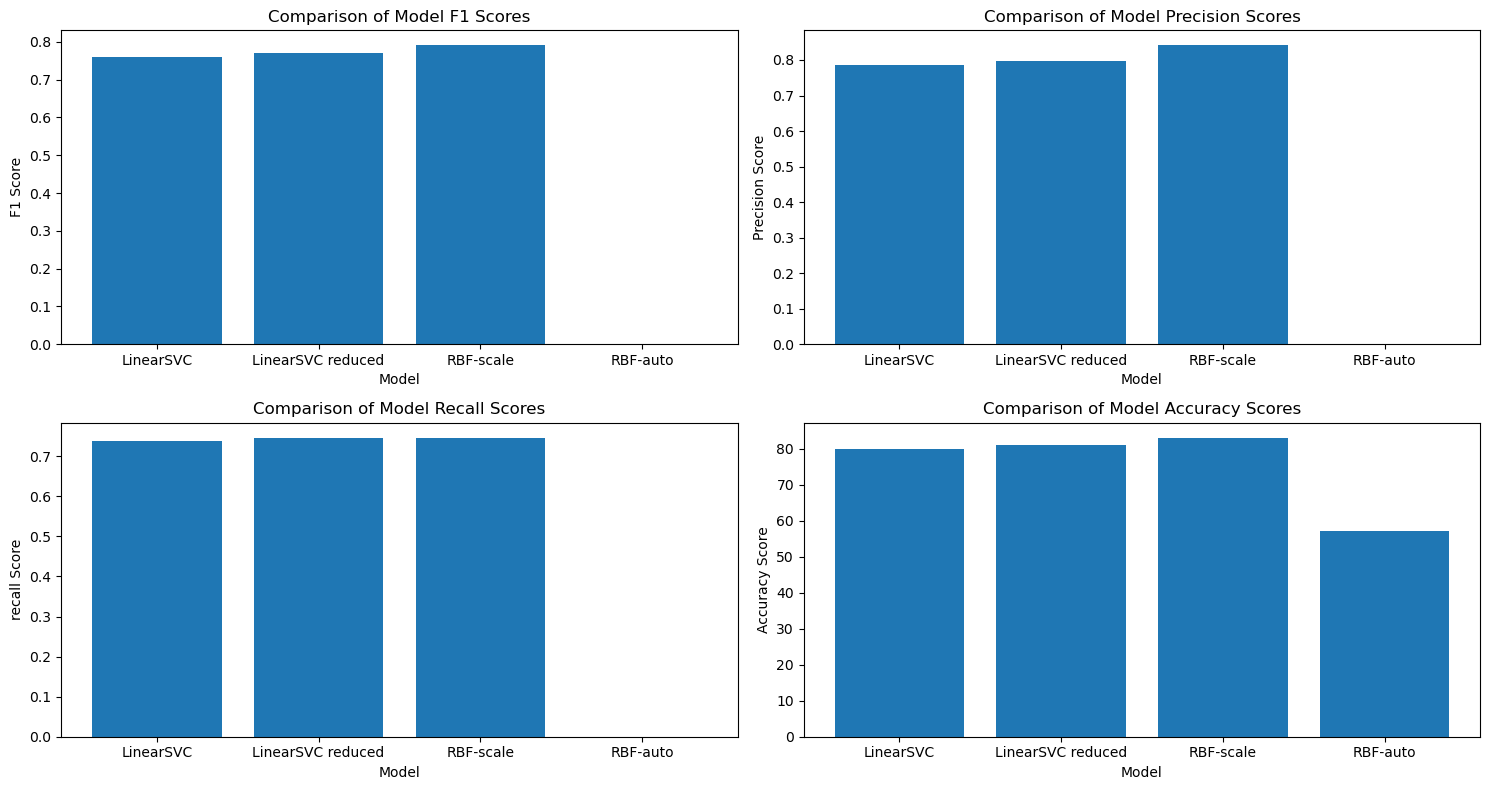

In [23]:
plt.clf()
fig, axes = plt.subplots(2,2, figsize = (15,8))
models = ['LinearSVC','LinearSVC reduced','RBF-scale','RBF-auto']

plt.subplot(2,2,1)
f1_scores = [orig_test_stats[1], test_tasts[1], rbf_test_tasts[1], auto_test_tasts[1]]
plt.bar(models, f1_scores)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Model F1 Scores')

plt.subplot(2,2,2)
f1_scores = [orig_test_stats[2], test_tasts[2], rbf_test_tasts[2], auto_test_tasts[2]]
plt.bar(models, f1_scores)
plt.xlabel('Model')
plt.ylabel('Precision Score')
plt.title('Comparison of Model Precision Scores')

plt.subplot(2,2,3)
f1_scores = [orig_test_stats[3], test_tasts[3], rbf_test_tasts[3], auto_test_tasts[3]]
plt.bar(models, f1_scores)
plt.xlabel('Model')
plt.ylabel('recall Score')
plt.title('Comparison of Model Recall Scores')

plt.subplot(2,2,4)
f1_scores = [orig_test_stats[0], test_tasts[0], rbf_test_tasts[0], auto_test_tasts[0]]
plt.bar(models, f1_scores)
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.tight_layout()
plt.show()

This plot compares all the 4 models that were trained above. We can see that the SVC with RBF kernel and scaled gamma is the best, as most metrics showcase, more crucially the recall.

Finally, we will train a Gaussian Naive Bayes Classifier on the dataset will the full dimensions.

In [24]:
clf = GaussianNB()
clf.fit(x_dense, y_train)

C:\Users\giorg\anaconda3\envs\rapids\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,priors,None
,var_smoothing,1e-09


In [25]:
print("Testing GaussianNB:")
gnb_train_stats = []
gnb_test_tasts = []

y_pred_train = clf.predict(x_dense)
train_accuracy = accuracy_score(y_train, y_pred_train)*100
train_pre = precision_score(y_train, y_pred_train)
train_re = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)
print(f'Train: Acc={train_accuracy:.2f}, F1:={train_f1:.2f}, pre={train_pre:.2f}, rec={train_re:.2f}')
gnb_train_stats.append(train_accuracy)
gnb_train_stats.append(train_f1)
gnb_train_stats.append(train_pre)
gnb_train_stats.append(train_re)

y_pred_test = clf.predict(xtest_dense)
test_accuracy = accuracy_score(y_test, y_pred_test)*100
test_pre = precision_score(y_test, y_pred_test)
test_re = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test: Acc={test_accuracy:.2f}, F1:={test_f1:.2f}, pre={test_pre:.2f}, rec={test_re:.2f}')
gnb_test_tasts.append(test_accuracy)
gnb_test_tasts.append(test_f1)
gnb_test_tasts.append(test_pre)
gnb_test_tasts.append(test_re)

print('----------')

Testing GaussianNB:
Train: Acc=88.79, F1:=0.88, pre=0.79, rec=1.00
Test: Acc=62.20, F1:=0.64, pre=0.54, rec=0.80
----------


We can see that performance has decreased on all metrics, while we can also observe over-fitting of the classifier on the training data.

This shows the advantage of the SVM when we have small number of samples in our dataset and many features. Despite its simplicity, SVM gives a decent solution to this problem.